# Data description

In [1]:
import os
import json
from itertools import chain

import bs4 as bs
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utilities import *

In [2]:
here = os.getcwd()
project_path = os.path.dirname(here)
data_path = os.path.join(project_path, "data")
visualizations_path = os.path.join(project_path, "visualizations")

## Senators distribution

In [3]:
senators_path = os.path.join(data_path, "session_29-12-2020_senators.csv")
senators = pd.read_csv(senators_path)
senators.head(2)

,name,vote,senator,province,party
0,Ana Claudia Almirón,positivo,ALMIRÓN ANA CLAUDIA,CORRIENTES,ALIANZA FRENTE PARA LA VICTORIA
1,Roberto Gustavo Basualdo,negativo,BASUALDO ROBERTO GUSTAVO,SAN JUAN,ALIANZA CAMBIEMOS SAN JUAN


In [4]:
party_correction = {"FRENTE TODOS": "FRENTE DE TODOS"}
senators["party"] = senators.party.map(
    lambda x: party_correction.get(x, x)
)

In [5]:
senators.describe()

,name,vote,senator,province,party
count,70,70,70,70,70
unique,70,4,70,24,26
top,Ana Claudia Almirón,positivo,ALMIRÓN ANA CLAUDIA,CORRIENTES,FRENTE DE TODOS
freq,1,38,1,3,15


In [6]:
senators_party_count = senators.party.value_counts().to_frame().reset_index()
save_dataframe(
    senators_party_count, folder=visualizations_path, filename="senators_party_count"
)
senators_province_count = senators.province.value_counts().to_frame().reset_index()
save_dataframe(
    senators_province_count, folder=visualizations_path, filename="senators_province_count"
)

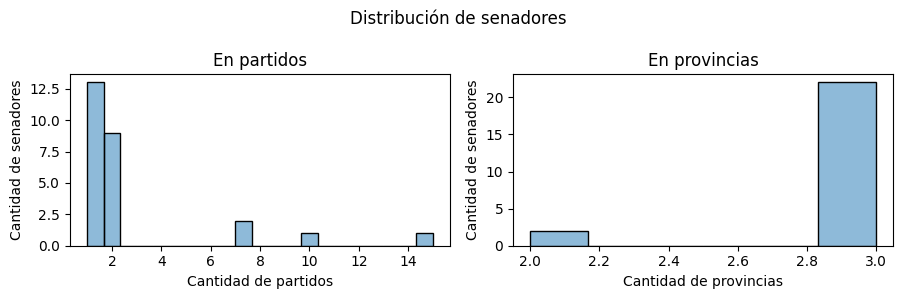

In [7]:
fig, axs = plt.subplots(1,2, figsize=(9,3))
datasets = [senators_party_count, senators_province_count]
titles = ["partido", "provincia"]
for i, (title, data) in enumerate(zip(titles, datasets)):
    sns.histplot(data=data, ax=axs[i])
    axs[i].set_title(f"En {title}s")
    axs[i].set_ylabel(f"Cantidad de senadores")
    axs[i].set_xlabel(f"Cantidad de {title}s")
    axs[i].get_legend().remove()
plt.suptitle("Distribución de senadores")
plt.tight_layout()
plt.savefig(os.path.join(visualizations_path,"senators_distribution.png"))

## Vote information

In [8]:
senators_vote = (
    senators
    .groupby(["party", "vote"])
    .size()
    .reset_index()
    .merge(senators_party_count)
    .assign(party=lambda x: x.party.str.title())
    .rename(columns={0:"n_votes", "count":"n_senators"})
    .sort_values(by=["n_senators","party"], ascending=[False,True])
    .reset_index(drop=True)
    .pivot_table(
        index=["party"], columns=["vote"],
        values=["n_votes"],fill_value=0, margins_name=["chicho", "cacho"])
)
senators_vote.columns = senators_vote.columns.get_level_values(1)
senators_vote.columns.name = ""

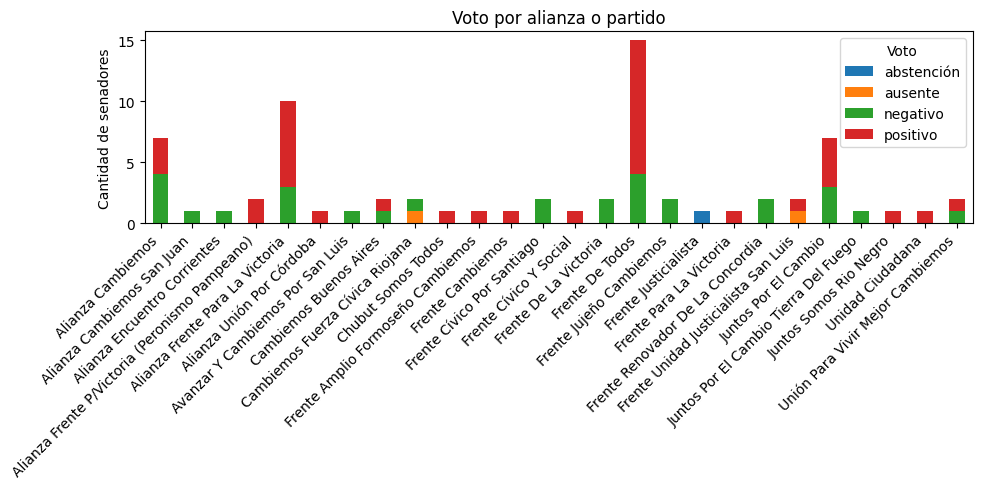

In [9]:
fig, ax = plt.subplots(figsize=(10,5))
senators_vote.plot(kind='bar', stacked=True, ax=ax)
ax.set_xlabel("")
ax.set_ylabel("Cantidad de senadores")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.legend(title="Voto")
plt.title("Voto por alianza o partido")
plt.tight_layout()
plt.savefig(os.path.join(visualizations_path,"senators_vote.png"))

In [10]:
senators_vote.reset_index(inplace=True)
save_dataframe(
    senators_vote[["party","positivo", "negativo", "ausente", "abstención"]],
    folder=visualizations_path, filename="senators_vote"
)

## Speech data

In [11]:
speech_path = os.path.join(data_path, "session_29-12-2020_discourse.xml")

with open(speech_path, "r") as f:
    speech_text = f.read() 

speech = bs.BeautifulSoup(speech_text, "lxml")

/home/macarena/repos/eddc/eddc-specialization-project/venv/lib/python3.10/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


In [12]:
speakers = [s.get_attribute_list("speaker") for s in speech.find_all("discourse", {"speech":"true"})]
speakers = list(set(chain(*speakers)))
speakers_map = dict(zip(list(map(preprocess_name,speakers)), speakers))

In [13]:
# check that each speaker match with only one senator
senators["speaker"] = senators.name.apply(
    lambda x: match_senator_name(x, list(speakers_map.keys()))
)
senators["n_speaker"] = senators.speaker.str.len().sort_values()
senators.sort_values(by=["n_speaker"], ascending=True, inplace=True)

In [14]:
# data to review
#senators[["name", "speaker"]].set_index("name").to_json(
#    "map_name2speaker.json", orient="index", indent=4, force_ascii=False
#)
#senators.drop(columns=["speaker", "n_speaker"], inplace=True)

In [15]:
with open("map_name2speaker.json", "r") as f:
    map_name2speaker = json.load(f)

In [16]:
senators["speaker"] = senators.name.apply(lambda x:
    speakers_map.get(map_name2speaker.get(x).get("speaker"))
)
senators.sort_index(inplace=True)

In [17]:
senators["speech"] = senators.speaker.apply(lambda x: assign_speech(x, speech))
senators["speech_prep"] = senators.speech.apply(lambda x: list(map(preprocess_text, x)))
senators["n_interventions"] = senators.speech_prep.str.len()
senators["n_tokens_interventions"] = senators.speech_prep.apply(
    lambda x: list(map(count_tokens, x))
)
senators["n_unique_tokens_interventions"] = senators.speech_prep.apply(
    lambda x: list(map(lambda z: count_tokens(z, unique=True), x))
)
senators["mean_tokens_interventions"] = senators["n_tokens_interventions"].apply(
    lambda x: np.mean(x) if len(x)>0 else 0
)
senators["mean_unique_tokens_interventions"] = senators["n_unique_tokens_interventions"].apply(
    lambda x: np.mean(x) if len(x)>0 else 0
)

In [18]:
senators_with_no_speech = (senators.speech.str.len()==0).sum()
mean_tt, median_tt, std_tt = calculate_univariant_metrics(
    senators.mean_tokens_interventions
)
mean_ut, median_ut, std_ut = calculate_univariant_metrics(
    senators.mean_unique_tokens_interventions
)
print(f"{senators_with_no_speech} senadores no intervinieron en la sesión.")
print(f"""
Tokens totales:
    - media: {round(mean_tt,2)}
    - mediana: {round(median_tt,2)}
    - desvío: {round(std_tt,2)}
Tokens únicos:
    - media: {round(mean_ut,2)}
    - mediana: {round(median_ut,2)}
    - desvío: {round(std_ut,2)}
""")

9 senadores no intervinieron en la sesión.

Tokens totales:
    - media: 811.65
    - mediana: 636.12
    - desvío: 714.79
Tokens únicos:
    - media: 296.47
    - mediana: 254.25
    - desvío: 238.68



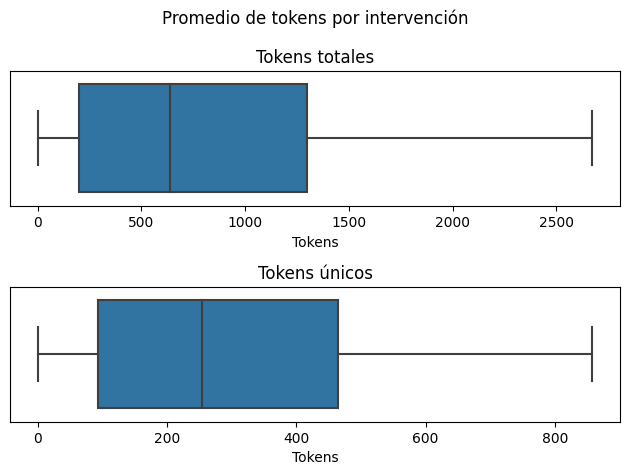

In [19]:
cols = ["mean_tokens_interventions", "mean_unique_tokens_interventions"]
titles = ["Tokens totales", "Tokens únicos"]

fig, axs = plt.subplots(2,1)

i = 0
for col,title in zip(cols, titles):
    sns.boxplot(data=senators, x=col, ax=axs[i])
    axs[i].set_title(title)
    axs[i].set_xlabel("Tokens")
    axs[i].tick_params(left=False)
    i += 1
plt.suptitle("Promedio de tokens por intervención")
plt.tight_layout()
plt.savefig(os.path.join(visualizations_path,"tokens_global.png"))

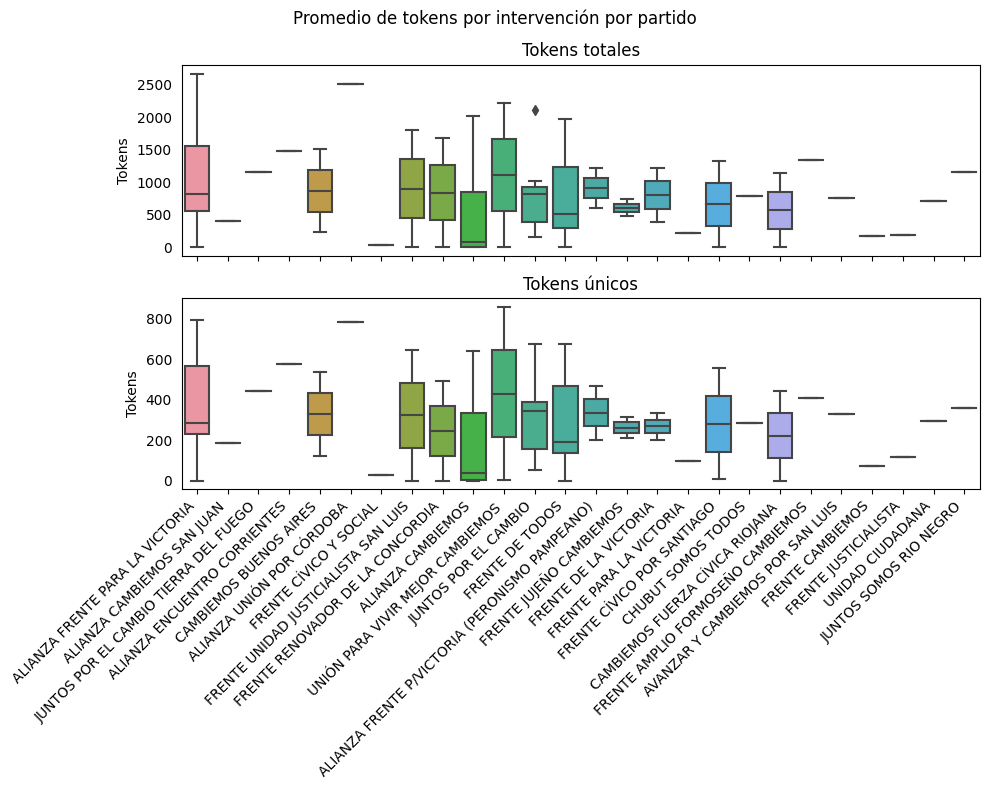

In [20]:
cols = ["mean_tokens_interventions", "mean_unique_tokens_interventions"]
titles = ["Tokens totales", "Tokens únicos"]

fig, axs = plt.subplots(2,1, figsize=(10,8), sharex=True)

i = 0
for col,title in zip(cols, titles):
    sns.boxplot(data=senators, x="party", y=col, ax=axs[i])
    axs[i].set_title(title)
    axs[i].set_xlabel("")
    axs[i].set_ylabel("Tokens")
    axs[i].tick_params(left=False)
    i += 1
plt.xticks(rotation=45, horizontalalignment="right")
plt.suptitle("Promedio de tokens por intervención por partido")
plt.tight_layout()
plt.savefig(os.path.join(visualizations_path,"tokens_party.png"))

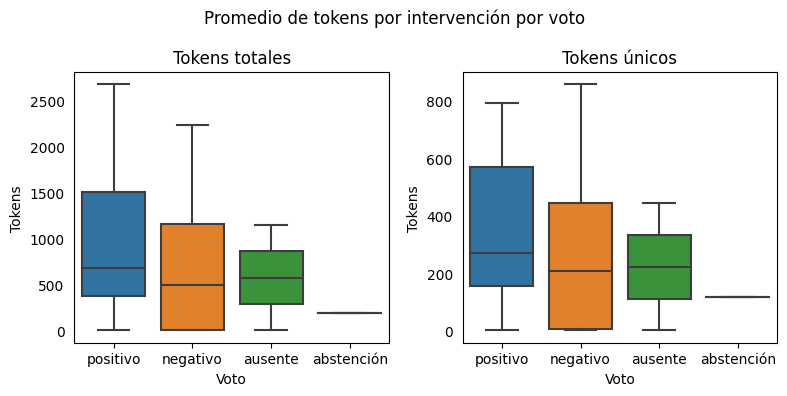

In [21]:
cols = ["mean_tokens_interventions", "mean_unique_tokens_interventions"]
titles = ["Tokens totales", "Tokens únicos"]

fig, axs = plt.subplots(1,2, figsize=(8,4))

i = 0
for col,title in zip(cols, titles):
    sns.boxplot(data=senators, x="vote", y=col, ax=axs[i])
    axs[i].set_title(title)
    axs[i].set_xlabel("Voto")
    axs[i].set_ylabel("Tokens")
    axs[i].tick_params(left=False)
    i += 1
plt.suptitle("Promedio de tokens por intervención por voto")
plt.tight_layout()
plt.savefig(os.path.join(visualizations_path,"tokens_vote.png"))

In [24]:
out_file = os.path.join(data_path, "session_speech.csv")
senators[["name", "vote", "speech"]].to_csv(out_file, index = False)